# The 4-way Intersection

`pyspect` can set up problems independently from implementations...
At this stage, we only need to import pyspect and select a pyspect language...

In [1]:
from math import pi

from pyspect import *
from pyspect.langs.ltl import *

TLT.select(ContinuousLTL)

## Environment

Let us first setup the 4-way intersection environment...

In [2]:
## CONSTANTS ##

# Define origin and size of area, makes it easier to scale up/down later on 
X0, XN = -1.2, 2.4
Y0, YN = -1.2, 2.4

In `pyspect`, we are able to define sets abstractly. They are evaluated [lazily](https://wikipedia.com). For ease-of-use we provide functions for this:
- `BoundedSet`
- `HalfSpaceSet`
- `...`

In [3]:
## TRAFFIC RULES ##

speedlimit = BoundedSet(v=(0.3, 0.6))

A benefit of using `pyspects` TLTs is that we can mix set definitions and logic statements...
To comply with `center`, a system needs to be member of all provided sets and other defined rules, e.g. `speedlimit`. 

In [4]:
## INTERSECTION CENTER ##

center = And(
    BoundedSet(x=(X0 + 0.2*XN, X0 + 0.8*XN), y=(Y0 + 0.2*YN, Y0 + 0.8*YN)),
    HalfSpaceSet(normal=[+1, +1], offset=[X0 + 0.25*XN, Y0 + 0.25*YN]),
    HalfSpaceSet(normal=[-1, +1], offset=[X0 + 0.75*XN, Y0 + 0.25*YN]),
    HalfSpaceSet(normal=[-1, -1], offset=[X0 + 0.75*XN, Y0 + 0.75*YN]),
    HalfSpaceSet(normal=[+1, -1], offset=[X0 + 0.25*XN, Y0 + 0.75*YN]),
    speedlimit
)

We see this here as well...

In [5]:
## ROADS ##

road_e = BoundedSet(y=(Y0 + 0.3*YN, Y0 + 0.5*YN), h=(-pi/5, +pi/5))
road_e = Or(And(road_e, speedlimit), center)

road_w = BoundedSet(y=(Y0 + 0.5*YN, Y0 + 0.7*YN), h=(+pi - pi/5, -pi + pi/5))
road_w = Or(And(road_w, speedlimit), center)

road_n = BoundedSet(x=(X0 + 0.5*XN, X0 + 0.7*XN), h=(+pi/2 - pi/5, +pi/2 + pi/5))
road_n = Or(And(road_n, speedlimit), center)

road_s = BoundedSet(x=(X0 + 0.3*XN, X0 + 0.5*XN), h=(-pi/2 - pi/5, -pi/2 + pi/5))
road_s = Or(And(road_s, speedlimit), center)

Later in this example, we will primarily work with entries and exits...

In [6]:
## ENTRIES ##

entry_e = And(BoundedSet(x=(X0 + 0.85*XN, X0 + 1.00*XN), y=(Y0 + 0.53*YN, Y0 + 0.67*YN)), road_w)
entry_w = And(BoundedSet(x=(X0 + 0.00*XN, X0 + 0.15*XN), y=(Y0 + 0.33*YN, Y0 + 0.47*YN)), road_e)
entry_n = And(BoundedSet(x=(X0 + 0.33*XN, X0 + 0.47*XN), y=(Y0 + 0.85*YN, Y0 + 1.00*YN)), road_s)
entry_s = And(BoundedSet(x=(X0 + 0.53*XN, X0 + 0.67*XN), y=(Y0 + 0.00*YN, Y0 + 0.15*YN)), road_n)


## EXITS ##

exit_e = And(BoundedSet(x=(X0 + 0.85*XN, X0 + 1.00*XN), y=(Y0 + 0.33*YN, Y0 + 0.47*YN)), road_e)
exit_w = And(BoundedSet(x=(X0 + 0.00*XN, X0 + 0.15*XN), y=(Y0 + 0.53*YN, Y0 + 0.67*YN)), road_w)
exit_n = And(BoundedSet(x=(X0 + 0.53*XN, X0 + 0.67*XN), y=(Y0 + 0.85*YN, Y0 + 1.00*YN)), road_n)
exit_s = And(BoundedSet(x=(X0 + 0.33*XN, X0 + 0.47*XN), y=(Y0 + 0.00*YN, Y0 + 0.15*YN)), road_s)

We can define new functions...

In [7]:
def FollowTo(constraint, goal_or_constraint, *more):
    if more: # 2nd arg is constraint
        return FollowTo(And(constraint, goal_or_constraint), *more)
    else: # 2nd arg is exit
        return Until(constraint, goal_or_constraint)

Three vehicles in the scenario must follow these rules...

In [8]:
vehicle_1 = FollowTo(Or(road_e, road_n), exit_n)

vehicle_2 = FollowTo(road_n, Not(vehicle_1), exit_n)

vehicle_3 = FollowTo(road_e, Not(vehicle_1), Not(vehicle_2), exit_e)

## Implementations

Implementations and set representations are completely general. To demonstrate, we define the simplest implementation.
`StrImpl` produces strings that "represent" the sets. This is completetly fine as well...  

In [9]:
class StrImpl(ContinuousLTL.Impl):

    def __init__(self, ndim: int) -> None:
        self.ndim = ndim

    def set_axes_names(self, *args):
        assert len(args) == self.ndim
        self._axes_names = args

    def axis(self, name: str) -> int:
        return self._axes_names.index(name)

    def axis_name(self, i: int) -> str:
        return self._axes_names[i]
    
    def axis_is_periodic(self, i: int) -> bool:
        return False

    def plane_cut(self, normal, offset, axes=None):
        return 'plane{...}'

    def empty(self):
        return 'empty{ }'
    
    def complement(self, vf):
        return f'({vf})^C'
    
    def intersect(self, vf1, vf2):
        return f'({vf1} ∩ {vf2})'

    def union(self, vf1, vf2):
        return f'({vf1} ∪ {vf2})'
    
    def reach(self, target, constraints=None):
        return f'Reach({target}, {constraints})'

    def avoid(self, target, constraints=None):
        return f'Avoid({target}, {constraints})'

In [10]:
impl = StrImpl(ndim=4)
impl.set_axes_names('x', 'y', 'h', 'v')

out = TLT.construct(vehicle_2).realize(impl)

print(out)

Reach(((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ (((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ ((empty{ })^C ∩ (plane{...} ∩ plane{...}))) ∪ ((((((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ plane{...}) ∩ plane{...}) ∩ plane{...}) ∩ plane{...}) ∩ ((empty{ })^C ∩ (plane{...} ∩ plane{...}))))), ((((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ ((empty{ })^C ∩ (plane{...} ∩ plane{...}))) ∪ ((((((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ plane{...}) ∩ plane{...}) ∩ plane{...}) ∩ plane{...}) ∩ ((empty{ })^C ∩ (plane{...} ∩ plane{...})))) ∩ (Reach(((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ (((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ ((empty{ })^C ∩ (plane{...} ∩ plane{...}))) ∪ ((((((((empty{ })^C ∩ (plane{...} ∩ plane{...})) ∩ (plane{...} ∩ plane{...})) ∩ plane{...}) ∩ plane

Implementation using `hj_reachability`.

In [11]:
import numpy as np
import hj_reachability as hj

class HJImpl(ContinuousLTL.Impl):

    solver_settings = hj.SolverSettings.with_accuracy("low")

    def __init__(self, dynamics, grid, time_horizon):
        self.grid = grid
        self.ndim = grid.ndim
        self.dynamics = dynamics
        self.timeline = self.new_timeline(time_horizon)
           
    def new_timeline(self, target_time, start_time=0, time_step=0.2):
        assert time_step > 0
        is_forward = target_time >= start_time
        target_time += 1e-5 if is_forward else -1e-5
        time_step *= 1 if is_forward else -1
        return np.arange(start_time, target_time, time_step)

    def set_axes_names(self, *args):
        assert len(args) == self.ndim
        self._axes_names = tuple(args)

    def axis(self, name: str) -> int:
        assert name in self._axes_names, f'Axis ({name=}) does not exist.'
        return self._axes_names.index(name)

    def axis_name(self, i: int) -> str:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return self._axes_names[i]

    def axis_is_periodic(self, i: int) -> bool:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return bool(self.grid._is_periodic_dim[i])

    def plane_cut(self, normal, offset, axes=None):
        data = np.zeros(self.grid.shape)
        axes = axes or list(range(self.grid.ndim))
        x = lambda i: self.grid.states[..., i]
        for i, k, m in zip(axes, normal, offset):
            data -= k*x(i) - k*m
        return data

    def empty(self):
        return np.ones(self.grid.shape)*np.inf
    
    def complement(self, vf):
        return np.asarray(-vf)
    
    def intersect(self, vf1, vf2):
        return np.maximum(vf1, vf2)

    def union(self, vf1, vf2):
        return np.minimum(vf1, vf2)
    
    def reach(self, target, constraints=None):
        self.dynamics.with_mode('reach')
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)
    
    def avoid(self, target, constraints=None):
        self.dynamics.with_mode('avoid')
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)

    def project_onto(self, vf, *idxs, keepdims=False):
        idxs = [len(vf.shape) + i if i < 0 else i for i in idxs]
        dims = [i for i in range(len(vf.shape)) if i not in idxs]
        return vf.min(axis=tuple(dims), keepdims=keepdims)

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))

100%|##########| 10.0000/10.0 [00:04<00:00,  2.03sim_s/s]
/tmp/ipykernel_42300/4215913817.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


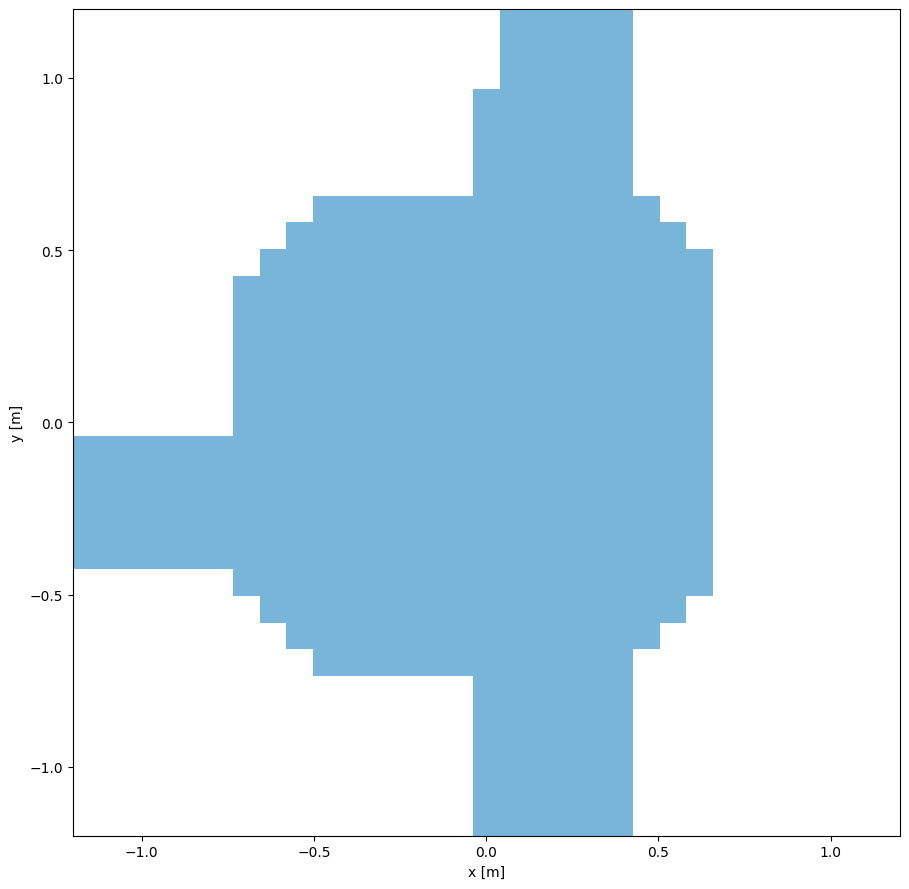

In [14]:
from hj_reachability.systems import Bicycle4D
from hj_reachability.plotting import *

reach_dynamics = Bicycle4D(min_steer=-5*pi/4, 
                           max_steer=+5*pi/4,
                           min_accel=-0.4,
                           max_accel=+0.4)

min_bounds = np.array([   X0,    Y0, -pi, +0.3])
max_bounds = np.array([XN+X0, YN+Y0, +pi, +0.8])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (31, 31, 25, 7),
                                                               periodic_dims=2)

impl = HJImpl(reach_dynamics, grid, 10)
impl.set_axes_names('x', 'y', 'h', 'v')

out = TLT.construct(vehicle_1).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out, 1, 2)),
    min_bounds=min_bounds, max_bounds=max_bounds,
)
fig.show()

In [13]:
print(TLT.construct(Empty()))
empty = TLT.construct(Empty())
foo = TLT.construct(And('lhs', Not(Empty())))
bar = TLT.construct(foo, lhs=center)
print('empty ', empty)
print('center', center)
print('foo   ', foo, foo._lmap)
print('bar   ', bar, bar._lmap)
bar.realize(impl)

TLT<ContinuousLTL>(EXACT, _000007fb9c436fdc)
empty  TLT<ContinuousLTL>(EXACT, _000007fb9e02d543)
center TLT<ContinuousLTL>(OVER, ('AND', ('AND', ('AND', ('AND', ('AND', '_000007fb9e03694c', '_000007fb9e033faf'), '_000007fb9e033fc1'), '_000007fb9e033fb8'), '_000007fb9e033fca'), '_000007fb9e03699d'))
foo    TLT<ContinuousLTL>(OVER, ('AND', ('lhs',), ('NOT', '_000007fb9e02c604'))) idict({'lhs': None})
bar    TLT<ContinuousLTL>(OVER, ('AND', ('AND', ('AND', ('AND', ('AND', ('AND', '_000007fb9e03694c', '_000007fb9e033faf'), '_000007fb9e033fc1'), '_000007fb9e033fb8'), '_000007fb9e033fca'), '_000007fb9e03699d'), ('NOT', ('_', '0', '0', '0', '0', '0', '7', 'f', 'b', '9', 'e', '0', '2', 'c', '6', '0', '4')))) idict({'lhs': None})


AssertionError: Cannot realize TLT, missing ['lhs']